In [1]:
import os
import pandas as pd
import numpy as np
import micromag as mg
import matplotlib.pyplot as plt
import matplotlib.patches
import pathlib

In [2]:
fig_dir = pathlib.Path("../..") / "paper" / "figures"

In [3]:
# Defina sua direção de referência (por exemplo, vetor unitário)
inc_ref, dec_ref = 30, 30
reference_vector = mg.angles_to_vector(inc_ref, dec_ref, 1)  # exemplo, ajuste conforme necessário

In [4]:
def angular_distance(vec_a, vec_b):
    # Produto escalar entre os vetores
    dot_product = np.dot(vec_a, vec_b)
    
    # Magnitudes dos vetores
    magnitude_a = np.linalg.norm(vec_a)
    magnitude_b = np.linalg.norm(vec_b)
    
    # Cálculo do cosseno do ângulo
    cos_theta = dot_product / (magnitude_a * magnitude_b)
    
    # Ângulo em radianos
    theta = np.rad2deg(np.arccos(cos_theta))
    # theta = np.arccos(np.clip(cos_theta, -1.0, 1.0))# Clipping para evitar erros numéricos
    return theta

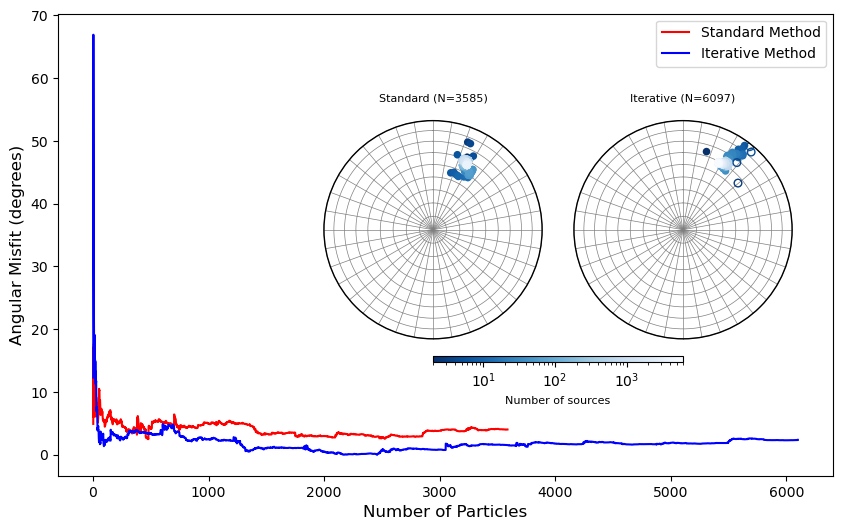

In [5]:
# Pasta onde os arquivos CSV estão localizados
csv_folder = "csv_files_45k_grains_per_mm3"
# Listas para armazenar os momentos dipolares
mx_all_standard, my_all_standard, mz_all_standard = [], [], []
mx_all_iterative, my_all_iterative, mz_all_iterative = [], [], []

# Listas para armazenar os valores de R²
r2_all_standard, r2_all_iterative = [], []

# Processar os arquivos da pasta
for file in os.listdir(csv_folder):
    if file.endswith("_standard.csv"):
        # Ler os arquivos padrão
        df_standard = pd.read_csv(os.path.join(csv_folder, file))
        mx_all_standard.extend(df_standard['mx_standard'].values)
        my_all_standard.extend(df_standard['my_standard'].values)
        mz_all_standard.extend(df_standard['mz_standard'].values)
        r2_all_standard.extend(df_standard['r_2_standard'].values)

    elif file.endswith("_iterative.csv"):
        # Ler os arquivos iterativos
        df_iterative = pd.read_csv(os.path.join(csv_folder, file))
        mx_all_iterative.extend(df_iterative['mx_iterative'].values)
        my_all_iterative.extend(df_iterative['my_iterative'].values)
        mz_all_iterative.extend(df_iterative['mz_iterative'].values)
        r2_all_iterative.extend(df_iterative['r_2_iterative'].values)

# Criar as listas com as soluções finais para os momentos dipolares
dipole_moment_standard = np.array([
    np.array(mx_all_standard), 
    np.array(my_all_standard), 
    np.array(mz_all_standard)
]).T

dipole_moment_iterative = np.array([
    np.array(mx_all_iterative), 
    np.array(my_all_iterative), 
    np.array(mz_all_iterative)
]).T

# Criar arrays para os valores de R²
r2_standard = np.array(r2_all_standard)
r2_iterative = np.array(r2_all_iterative)

r2 = 0.85#-np.inf
dipole_moment_standard = dipole_moment_standard[r2_standard >= r2]
dipole_moment_iterative = dipole_moment_iterative[r2_iterative >= r2]

r2_standard = r2_standard[r2_standard >= r2]
r2_iterative = r2_iterative[r2_iterative >= r2]

indices_standard = np.argsort(r2_standard[r2_standard >= r2])[::-1]
indices_iterative = np.argsort(r2_iterative[r2_iterative >= r2])[::-1]

angular_distance_standard = []
angular_distance_iterative = []
vector_sum_standard, vector_sum_iterative = [], []
inc_standard, dec_standard = [], []
inc_iterative, dec_iterative = [], []
# Calculando a distância angular para a metodologia "standard"
for n in range(2, len(dipole_moment_standard[:, 0])):
    vector_sum = np.sum(dipole_moment_standard[:n, :], axis=0)
    inc, dec, _ = mg.vector_to_angles(vector_sum)
    vector_sum_standard.append(vector_sum)
    inc_standard.append(inc)
    dec_standard.append(dec)
    # Calcula a distância angular
    angular_distance_value = angular_distance(reference_vector, vector_sum)
    angular_distance_standard.append(angular_distance_value)

# Calculando a distância angular para a metodologia "iterative"
for n in range(2, len(dipole_moment_iterative[:, 0])):
    vector_sum = np.sum(dipole_moment_iterative[:n, :], axis=0)
    inc, dec, _ = mg.vector_to_angles(vector_sum)
    vector_sum_iterative.append(vector_sum)
    inc_iterative.append(inc)
    dec_iterative.append(dec)

    # Calcula a distância angular
    angular_distance_value = angular_distance(reference_vector, vector_sum)
    angular_distance_iterative.append(angular_distance_value)



# Número de partículas é equivalente a 'n' nos loops, então você pode usar o range de 'n' para o eixo x
num_particles_standard = list(range(2, len(dipole_moment_standard[:, 0])))
num_particles_iterative = list(range(2, len(dipole_moment_iterative[:, 0])))

# Criar a figura principal
fig, ax = plt.subplots(figsize=(10, 6))

# Plotando as distâncias angulares
ax.plot(num_particles_standard, angular_distance_standard, label='Standard Method', c='r')
ax.plot(num_particles_iterative, angular_distance_iterative, label='Iterative Method', c='b')
ax.set_xlabel('Number of Particles', fontsize=12)
ax.set_ylabel('Angular Misfit (degrees)', fontsize=12)
ax.legend()
# ax.grid(True)

# Definindo áreas para as projeções estereográficas dentro do gráfico principal
# Definindo a posição das projeções dentro do gráfico com (x0, y0, width, height)
projection_positions = [
    (0.3, 0.32, 0.4, 0.4),  # Posição do gráfico de projeção padrão
    (0.55, 0.32, 0.4, 0.4)   # Posição do gráfico de projeção iterativo
]

# Títulos e dados para os subgráficos
titles = [
    "Standard",
    "Iterative"
]

datasets = [
    (inc_standard, dec_standard, vector_sum_standard),
    (inc_iterative, dec_iterative, vector_sum_iterative)
]

cmap = "Blues_r"  # Escolha um colormap
maximum = np.max([len(inc_standard), len(inc_iterative)])
cmap_norm = matplotlib.colors.LogNorm #Normalize
# Plotando as projeções estereográficas nas posições definidas
for pos, (title, (inc, dec, vector_sum)) in zip(projection_positions, zip(titles, datasets)):
    # Calcular novo amplitude
    new_amp = range(2, len(inc) + 2)
    
    # Recalcular o vetor somado com nova amplitude
    new_vector_sum = mg.angles_to_vector(inc, dec, new_amp)
    
    # Criar a projeção estereográfica
    projection = mg.StereographicProjection(new_vector_sum)
    
    # Adicionar a área para o gráfico de projeção estereográfica
    inset_ax = fig.add_axes(pos)
    
    # Configurar kwargs para o scatter plot
    kwargs = dict(s=30, cmap=cmap, vmin=2, vmax=maximum, cmap_norm=cmap_norm)
    
    # Plotar a projeção estereográfica no inset
    tmp = projection.plot(ax=inset_ax, add_ticks=False,  **kwargs)
    
    # Adicionar a quantidade de fontes no título
    num_sources = len(inc)
    inset_ax.set_title(f"{title} (N={num_sources})", fontsize=8)

# Configuração da barra de cores compartilhada
clb = fig.colorbar(
    tmp,
    ax=ax,
    cax=fig.add_axes([0.5, 0.3, 0.25, 0.01]),
    # format="%.0g",
    orientation="horizontal",
)
clb.set_label(label="Number of sources", fontsize=8)
clb.ax.tick_params(labelsize=10)

# plt.tight_layout()  # Ajusta o layout automaticamente
plt.show()


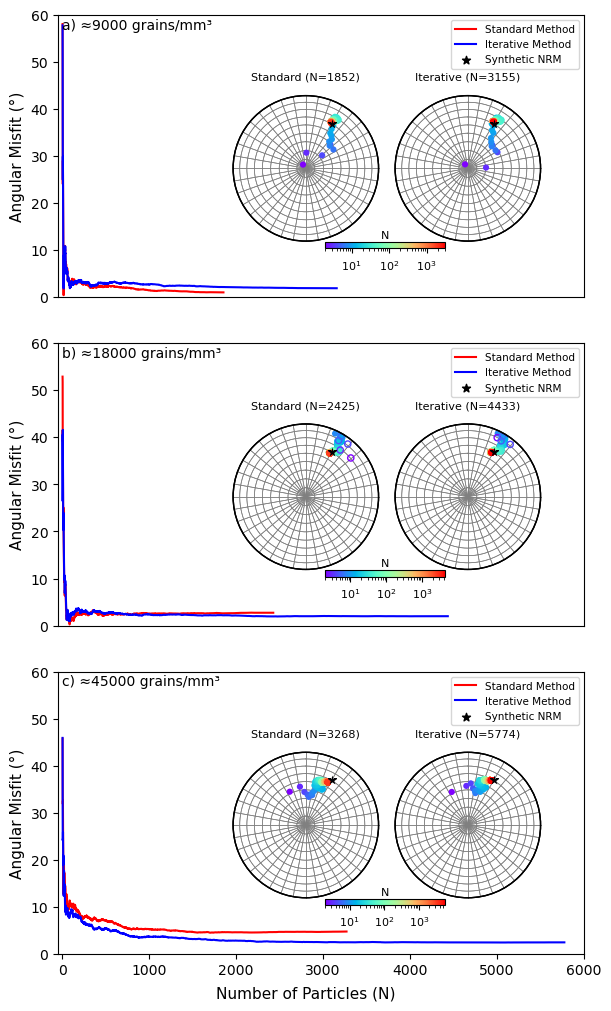

In [8]:
# Lista de pastas a serem processadas
# Lista de pastas a serem processadas
csv_folders = ["csv_files_9k_grains_per_mm3",
               "csv_files_18k_grains_per_mm3",
               "csv_files_45k_grains_per_mm3"]

texts = ["a) ≈9000 grains/mm³", "b) ≈18000 grains/mm³", "c) ≈45000 grains/mm³"]
# Criar a figura principal com subfiguras
fig = plt.figure(figsize=(6, 10), constrained_layout=True)
fig.set_constrained_layout_pads(hspace=0.025)
subfigs = fig.subfigures(nrows=3, ncols=1)

# for subfig, csv_folder in zip(subfigs, csv_folders):
for i, (subfig, csv_folder, text) in enumerate(zip(subfigs, csv_folders, texts)):
    # Listas para armazenar os momentos dipolares
    mx_all_standard, my_all_standard, mz_all_standard = [], [], []
    mx_all_iterative, my_all_iterative, mz_all_iterative = [], [], []
    
    # Listas para armazenar os valores de R²
    r2_all_standard, r2_all_iterative = [], []
    
    # Processar os arquivos da pasta
    for file in os.listdir(csv_folder):
        if file.endswith("_standard.csv"):
            df_standard = pd.read_csv(os.path.join(csv_folder, file))
            mx_all_standard.extend(df_standard['mx_standard'].values)
            my_all_standard.extend(df_standard['my_standard'].values)
            mz_all_standard.extend(df_standard['mz_standard'].values)
            r2_all_standard.extend(df_standard['r_2_standard'].values)
        elif file.endswith("_iterative.csv"):
            df_iterative = pd.read_csv(os.path.join(csv_folder, file))
            mx_all_iterative.extend(df_iterative['mx_iterative'].values)
            my_all_iterative.extend(df_iterative['my_iterative'].values)
            mz_all_iterative.extend(df_iterative['mz_iterative'].values)
            r2_all_iterative.extend(df_iterative['r_2_iterative'].values)
    
    dipole_moment_standard = np.array([mx_all_standard, my_all_standard, mz_all_standard]).T
    dipole_moment_iterative = np.array([mx_all_iterative, my_all_iterative, mz_all_iterative]).T
    
    r2_standard = np.array(r2_all_standard)
    r2_iterative = np.array(r2_all_iterative)
    
    r2 = 0.9
    dipole_moment_standard = dipole_moment_standard[r2_standard >= r2]
    dipole_moment_iterative = dipole_moment_iterative[r2_iterative >= r2]
    
    r2_standard = r2_standard[r2_standard >= r2]
    r2_iterative = r2_iterative[r2_iterative >= r2]

    ###############################################################
    # sort the sources from the strongest to weakest
    norm_standard = np.linalg.norm(dipole_moment_standard, axis=1)
    norm_iterative = np.linalg.norm(dipole_moment_iterative, axis=1)
    indices_standard = np.argsort(norm_standard)[::-1]
    indices_iterative = np.argsort(norm_iterative)[::-1]
    dipole_moment_standard = dipole_moment_standard[indices_standard]
    dipole_moment_iterative = dipole_moment_iterative[indices_iterative]
    r2_standard = r2_standard[indices_standard]
    r2_iterative = r2_iterative[indices_iterative]
    ###############################################################
    
    
    angular_distance_standard, angular_distance_iterative = [], []
    inc_standard, dec_standard = [], []
    inc_iterative, dec_iterative = [], []
    
    for n in range(2, len(dipole_moment_standard[:, 0])):
        vector_sum = np.sum(dipole_moment_standard[:n, :], axis=0)
        inc, dec, _ = mg.vector_to_angles(vector_sum)
        inc_standard.append(inc)
        dec_standard.append(dec)
        angular_distance_standard.append(angular_distance(reference_vector, vector_sum))
    
    for n in range(2, len(dipole_moment_iterative[:, 0])):
        vector_sum = np.sum(dipole_moment_iterative[:n, :], axis=0)
        inc, dec, _ = mg.vector_to_angles(vector_sum)
        inc_iterative.append(inc)
        dec_iterative.append(dec)
        angular_distance_iterative.append(angular_distance(reference_vector, vector_sum))
    
    num_particles_standard = list(range(2, len(dipole_moment_standard[:, 0])))
    num_particles_iterative = list(range(2, len(dipole_moment_iterative[:, 0])))
    
    axs = subfig.subplots(1, 1)
    axs.plot(num_particles_standard, angular_distance_standard, label='Standard Method', c='r')
    axs.plot(num_particles_iterative, angular_distance_iterative, label='Iterative Method', c='b')
    # axs.set_xlabel('Number of Particles', fontsize=12)
    axs.set_ylabel('Angular Misfit (°)', fontsize=11)
    y_var = 60
    axs.set_ylim(0,y_var)
    axs.set_xlim(-50,6000)
    axs.scatter([],[], marker='*',label='Synthetic NRM', c='k')
    # axs.axhline(y=10, xmin=2/5000, xmax=1, color='k', ls='dotted')
    axs.legend(fontsize=7.5)
    axs.text(0, y_var-3, text)
    
    
    projection_positions = [(0.25, 0.24, 0.5, 0.5), (0.52, 0.24, 0.5, 0.5)]
    titles = ["Standard", "Iterative"]
    datasets = [(inc_standard, dec_standard), (inc_iterative, dec_iterative)]
    cmap = "rainbow"
    maximum = max(len(inc_standard), len(inc_iterative))
    cmap_norm = matplotlib.colors.LogNorm
    
    for pos, (title, (inc, dec)) in zip(projection_positions, zip(titles, datasets)):
        new_amp = range(2, len(inc) + 2)
        new_vector_sum = mg.angles_to_vector(inc, dec, new_amp)
        projection = mg.StereographicProjection(new_vector_sum)
        projection_R = mg.StereographicProjection(np.reshape(reference_vector,(1,3)))
        inset_ax = subfig.add_axes(pos)
        kwargs = dict(s=20, cmap=cmap, vmin=2, vmax=maximum, cmap_norm=cmap_norm)
        tmp = projection.plot(ax=inset_ax, add_ticks=False, **kwargs)
        tmp_R = projection_R.plot(ax=inset_ax, add_ticks=False, s=50, marker='*')
        inset_ax.set_title(f"{title} (N={len(inc)})", fontsize=8)

    clb = fig.colorbar(
        tmp,
        ax=inset_ax,
        cax=subfig.add_axes([0.5325, 0.24, 0.2, 0.02]),
        # format="%.0g",
        orientation="horizontal",
    )
    clb.set_label(label="N", fontsize=8, labelpad=-30, loc="center")
    clb.ax.tick_params(labelsize=8)
    # subfig.suptitle(f"Results for {csv_folder}", fontsize=14)

    # Remove ticks do eixo x, exceto no último subfigura
    if i < len(subfigs) - 1:
        # axs.set_xticklabels([])
        axs.xaxis.label.set_color('white')
        axs.tick_params(axis='x', colors='white')
        ax.xaxis.set_tick_params(labelcolor='white')
        
    # else:
        # axs.set_xlabel('Number of Particles (N)', fontsize=12)

fig.supxlabel("Number of Particles (N)", fontsize=11)
fig.savefig(fig_dir / "synthetic-different-densities-stereoplot.png", dpi=300, facecolor='w', bbox_inches='tight')

plt.show()


In [7]:
stop here

SyntaxError: invalid syntax (4067800170.py, line 1)

In [ ]:
import numpy as np

# Function for rotation around the X-axis
def rotate_x(vector, theta):
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(theta), -np.sin(theta)],
                   [0, np.sin(theta), np.cos(theta)]])
    return np.dot(Rx, vector)

# Function for rotation around the Y-axis
def rotate_y(vector, theta):
    Ry = np.array([[np.cos(theta), 0, np.sin(theta)],
                   [0, 1, 0],
                   [-np.sin(theta), 0, np.cos(theta)]])
    return np.dot(Ry, vector)

# Function for rotation around the Z-axis
def rotate_z(vector, theta):
    Rz = np.array([[np.cos(theta), -np.sin(theta), 0],
                   [np.sin(theta), np.cos(theta), 0],
                   [0, 0, 1]])
    return np.dot(Rz, vector)

# Example usage
vector = np.array([0.00001, 0.00001, 0.99999])  # Initial vector
theta = np.radians(-90)  # Rotation angle in radians (90 degrees)

# Rotate the vector around each axis
vector_rotated_x = rotate_x(vector, theta)
vector_rotated_y = rotate_y(vector, theta)
vector_rotated_z = rotate_z(vector, theta)

print("Rotated around X-axis:", vector_rotated_x)
print("Rotated around Y-axis:", vector_rotated_y)
print("Rotated around Z-axis:", vector_rotated_z)


In [ ]:
print(mg.vector_to_angles(vector))
print(mg.vector_to_angles(vector_rotated_x))
print(mg.vector_to_angles(vector_rotated_y))
print(mg.vector_to_angles(vector_rotated_z))

In [ ]:
# projection = mg.StereographicProjection(np.array([vector]))
# tmp = projection.plot()
# projection = mg.StereographicProjection(np.array([vector_rotated_x]))
# tmp = projection.plot()
# projection = mg.StereographicProjection(np.array([vector_rotated_y]))
# tmp = projection.plot()
# projection = mg.StereographicProjection(np.array([vector_rotated_z]))
# tmp = projection.plot()

In [ ]:
# Example usage
vector = np.array([8.0135034E-2,1.5384976E-1,2.0500925E-1])  # Initial vector
  # Rotation angle in radians (90 degrees)
# Rotate the vector around each axis

vector_rotated_1 = rotate_x(vector, np.radians(180))
vector_rotated_2 = rotate_y(vector_rotated_1, np.radians(-90))


projection = mg.StereographicProjection(np.array([vector]))
tmp = projection.plot()
projection = mg.StereographicProjection(np.array([vector_rotated_1]))
tmp = projection.plot()
projection = mg.StereographicProjection(np.array([vector_rotated_2]))
tmp = projection.plot()

In [ ]:
mg.vector_to_angles(vector_rotated_2)

In [ ]:
mg.vector_to_angles([1.7154274E-1,1.7466264E-1,2.3178508E-1])

In [ ]:
# Example usage
vector = np.array([0.129629, 0.056749, 0.049137])
vector_rotated_1 = rotate_y(vector, np.radians(-90))

vector = mg.angles_to_vector(19.4, 319.5, 1)
projection = mg.StereographicProjection(np.array([vector]))
tmp = projection.plot()
print(mg.vector_to_angles(vector))

vector = np.array([0.129629, 0.056749, 0.049137])
# vector = mg.angles_to_vector(19.4, 139, 1)
projection = mg.StereographicProjection(np.array([vector]))
tmp = projection.plot()
print(mg.vector_to_angles(vector))

In [ ]:
# vector = mg.angles_to_vector(19.4, 319.5, 1)
# projection = mg.StereographicProjection(np.array([vector]))
# tmp = projection.plot()


# vector_rotated_1 = rotate_z(vector, np.radians(-40.5))
# projection = mg.StereographicProjection(np.array([vector_rotated_1]))
# tmp = projection.plot()


# vector_rotated_2 = rotate_x(vector_rotated_1, np.radians(19.4))
# projection = mg.StereographicProjection(np.array([vector_rotated_2]))
# tmp = projection.plot()


vector = mg.angles_to_vector(19.4, 319.5, 1)
projection = mg.StereographicProjection(np.array([vector]))
tmp = projection.plot()


vector_rotated_1 = rotate_z(vector, np.radians(-40.5+180))
projection = mg.StereographicProjection(np.array([vector_rotated_1]))
tmp = projection.plot()


vector_rotated_2 = rotate_x(vector_rotated_1, np.radians(90-19.4))
projection = mg.StereographicProjection(np.array([vector_rotated_2]))
tmp = projection.plot()

In [ ]:
# vector =  np.array([0.129629, 0.056749, 0.049137])
# projection = mg.StereographicProjection(np.array([vector]))
# tmp = projection.plot()


# vector_rotated_1 = rotate_z(vector, np.radians(-40.5))
# projection = mg.StereographicProjection(np.array([vector_rotated_1]))
# tmp = projection.plot()


# vector_rotated_2 = rotate_x(vector_rotated_1, np.radians(19.4))
# projection = mg.StereographicProjection(np.array([vector_rotated_2]))
# tmp = projection.plot()

vector = np.array([0.129629, 0.056749, 0.049137])
projection = mg.StereographicProjection(np.array([vector]))
tmp = projection.plot()


vector_rotated_1 = rotate_z(vector, np.radians(-40.5+180))
projection = mg.StereographicProjection(np.array([vector_rotated_1]))
tmp = projection.plot()


vector_rotated_2 = rotate_x(vector_rotated_1, np.radians(90-19.4))
projection = mg.StereographicProjection(np.array([vector_rotated_2]))
tmp = projection.plot()

In [ ]:
print(mg.vector_to_angles(vector_rotated_2))

In [ ]:
vector = mg.angles_to_vector(19.0, 139.4, 5.06E-05)
print(vector)
projection = mg.StereographicProjection(np.array([vector]))
tmp = projection.plot()


vector_rotated_1 = rotate_z(vector, np.radians(139.4-180))
projection = mg.StereographicProjection(np.array([vector_rotated_1]))
tmp = projection.plot()


vector_rotated_2 = rotate_x(vector_rotated_1, np.radians(90-19.0))
projection = mg.StereographicProjection(np.array([vector_rotated_2]))
tmp = projection.plot()

In [ ]:
vector = np.array([0.075826, 0.095687, 0.068544])
projection = mg.StereographicProjection(np.array([vector]))
tmp = projection.plot()


vector_rotated_1 = rotate_z(vector, np.radians(139.4-180))
projection = mg.StereographicProjection(np.array([vector_rotated_1]))
tmp = projection.plot()


vector_rotated_2 = rotate_x(vector_rotated_1, np.radians(90-19.0))
projection = mg.StereographicProjection(np.array([vector_rotated_2]))
tmp = projection.plot()

In [ ]:
print(mg.vector_to_angles(vector_rotated_2))

In [ ]:
print(np.linalg.norm(np.array([0.129629, 0.056749, 0.049137])))
print(np.linalg.norm(np.array([0.075826, 0.095687, 0.068544])))

In [ ]:
vector = mg.angles_to_vector(0, 0, 1)
projection = mg.StereographicProjection(np.array([vector]))
tmp = projection.plot()


vector_rotated_1 = rotate_x(vector, np.radians(90))

projection = mg.StereographicProjection(np.array([vector_rotated_1]))
tmp = projection.plot()


vector = mg.angles_to_vector(19.0, 139.4, 1)
projection = mg.StereographicProjection(np.array([vector]))
tmp = projection.plot()


vector_rotated_1 = rotate_x(vector, np.radians(90))

projection = mg.StereographicProjection(np.array([vector_rotated_1]))
tmp = projection.plot()

In [ ]:
print(mg.vector_to_angles(vector_rotated_1))

In [ ]:
vector = mg.angles_to_vector(90, 0, 1)
projection = mg.StereographicProjection(np.array([vector]))
tmp = projection.plot()


vector_rotated_1 = rotate_z(vector, np.radians(90))
projection = mg.StereographicProjection(np.array([vector_rotated_1]))
tmp = projection.plot()

vector_rotated_2 = rotate_x(vector_rotated_1, np.radians(90))
projection = mg.StereographicProjection(np.array([vector_rotated_2]))
tmp = projection.plot()


vector = mg.angles_to_vector(19.4, 319.5, 1)
projection = mg.StereographicProjection(np.array([vector]))
tmp = projection.plot()


vector_rotated_1 = rotate_z(vector, np.radians(90))
projection = mg.StereographicProjection(np.array([vector_rotated_1]))
tmp = projection.plot()

vector_rotated_2 = rotate_x(vector_rotated_1, np.radians(90))
projection = mg.StereographicProjection(np.array([vector_rotated_2]))
tmp = projection.plot()

In [ ]:
print(mg.vector_to_angles(vector_rotated_2))

In [ ]:
vector = np.array([1.7154274E-1,1.7466264E-1,2.3178508E-1])
dec, inc =186.3, -85.6
# dec, inc = 181.2,  04.4
# dec, inc = 008.9, -86.3
dec, inc = 319.5,  19.4
# dec, inc = 139.4,  19.0

vector = mg.angles_to_vector(inc, dec, 1)


vector = rotate_z(vector, np.radians(-145))
vector = rotate_x(vector, np.radians(-90))


projection = mg.StereographicProjection(np.array([vector]))
tmp = projection.plot()




# vector_rotated_1 = rotate_x(vector, np.radians(-90))
# projection = mg.StereographicProjection(np.array([vector_rotated_1]))
# tmp = projection.plot()


print(mg.vector_to_angles(vector))

In [ ]:
vector = np.array([2.1177527E-3,-4.2573891E-5,-5.6653686E-5])

# Tijolo NRM
vector = np.array([2.5280961E-3,-8.5143836E-4,6.3315285E-4]) # de frente
# vector = np.array([-4.1930593E-3,-4.6497890E-3,-2.5026357E-3]) # de costas

# VNU IRM 1T
# vector = np.array([1.2739538E-2,1.2818826E-3,7.5978486E-4]) # de frente
# vector = np.array([2.1177527E-3,-4.2573891E-5,-5.6653686E-5]) # de costas


# vector = rotate_y(vector, np.radians(180))
# vector = rotate_z(vector, np.radians(-90))
# vector = rotate_z(vector, np.radians(180))



projection = mg.StereographicProjection(np.array([vector]))
tmp = projection.plot()


print(mg.vector_to_angles(vector))

In [ ]:
# dec, inc = 319.5,  19.4
dec, inc = 139.4,  19.0

# dec, inc = 008.9, -86.3
# dec, inc = 186.3, -85.6

# dec, inc = 316.8, -48.9
# dec, inc = 134.4, -50.1

dec, inc = 190.1,  -58
dec, inc = 141.7, 18.8
dec, inc = 20.8, 38
# dec, inc = 174, -10

vector = mg.angles_to_vector(inc, dec, 1)

# vector = rotate_z(vector, np.radians(90))
vector = rotate_x(vector, np.radians(-90))


projection = mg.StereographicProjection(np.array([vector]))
tmp = projection.plot()

print(mg.vector_to_angles(vector))

In [ ]:
def rotate_vector(r_vector, inc, dec):
    theta = np.deg2rad(90+inc)
    phi = np.deg2rad(90-dec)

    x = r_vector[0]
    y = r_vector[1]
    z = r_vector[2]

    rotatated_vector = [
        np.cos(phi)*(x*np.cos(theta)+z*np.sin(theta))-y*np.sin(phi),
        np.sin(phi)*(x*np.cos(theta)+z*np.sin(theta))+y*np.cos(phi),
        -x*np.sin(theta)+z*np.cos(theta)
    ]
    return np.asanyarray(rotatated_vector)

In [ ]:
import magali as ma



rotatated_vector = ma.rotate_vector(vector, 180, 0)

projection = mg.StereographicProjection(np.array([rotatated_vector]))
tmp = projection.plot()

print(mg.vector_to_angles(rotatated_vector))